# Prolific Study Evaluation
This notebook loads and processes the raw data collected on Supabase from the online human study done via Prolific.
It reconstructs participant-level and trial-level responses from the stored jsPsych logs,
and prepares clean analysis tables for downstream statistical evaluation.

In [2]:
import os
from dotenv import load_dotenv
from supabase import create_client
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

load_dotenv()

SUPABASE_URL = "https://utwhgfveotpusdjopcnl.supabase.co"
SUPABASE_KEY = os.environ["SUPABASE_SERVICE_ROLE"]

supabase = create_client(SUPABASE_URL, SUPABASE_KEY)

In [10]:
# Read out results table and print as dataframe
response = supabase.table("results").select("*").execute()

rows = response.data
df_raw = pd.DataFrame(rows)

# Drop all test and debug participants
df_raw = df_raw[(~df_raw['prolific_pid'].str.startswith('DEBUG')) &
    (~df_raw['prolific_pid'].str.startswith('TEST_'))
].copy()

display(df_raw)
print(df_raw.shape)

,id,prolific_pid,profile_id,exit_reason,created_at,data,exit_time,experiment_start_time,profile_index
55,9c0d06ee-31ab-4c79-9f29-60340eb12bc2,5997043dbbe84800017964a7,profile_6_last,failed_distractor,2026-01-28T12:57:10.075912+00:00,"[{'rt': 11700, 'study_id': '6962232f30c21461e6...",1769605029862,1769604712731,67
56,cae0bb77-d57a-41ca-8dd0-f86f78a6d8da,5a381de00006450001bf2691,profile_17_last,completed,2026-01-28T13:01:09.976787+00:00,"[{'rt': 14626, 'study_id': '6962232f30c21461e6...",1769605269189,1769604706487,17
57,5234326d-6ea1-49fb-93af-ee75e3984bec,676061b0d6e01e2e9548a4b9,profile_23_last,completed,2026-01-28T13:01:43.657952+00:00,"[{'rt': 21763, 'study_id': '6962232f30c21461e6...",1769605302694,1769604839827,31
58,da575643-83eb-4e38-80ce-03c10cd672cd,5bf8a27021a4e1000194fc76,profile_2_last,completed,2026-01-28T13:06:27.084044+00:00,"[{'rt': 14676, 'study_id': '6962232f30c21461e6...",1769605586286,1769605024569,45
59,22802372-74d0-411e-b879-ad9fdd2cf510,6146548679f86b7cb069e7f7,profile_11_last,completed,2026-01-28T13:07:56.910077+00:00,"[{'rt': 17468, 'study_id': '6962232f30c21461e6...",1769605676363,1769604826317,5
60,8d8195d4-b457-4dc8-8759-55a0fd0bdd29,5c5cad3e4ee81200018eafe2,profile_33_last,completed,2026-01-28T13:08:39.759393+00:00,"[{'rt': 12588, 'study_id': '6962232f30c21461e6...",1769605719886,1769604862872,53
61,1a28d289-0ebb-4d80-8695-5706704a0021,6053e01a6a8e8516ba7d47a7,profile_3_first,completed,2026-01-28T13:11:20.176687+00:00,"[{'rt': 17185, 'study_id': '6962232f30c21461e6...",1769605879714,1769604911837,60
62,af0da243-8692-4325-8db2-4342e07029c7,571bdaa76b0894001362f780,profile_7_first,completed,2026-01-28T13:15:48.124049+00:00,"[{'rt': 1575, 'study_id': '6962232f30c21461e6a...",1769606146541,1769605546811,68
63,6950a956-3a7a-4d54-ada1-1895374aa902,676063838d4db0d3eaa69c2b,profile_13_last,completed,2026-01-28T13:17:42.084933+00:00,"[{'rt': 1414, 'study_id': '6962232f30c21461e6a...",1769606181795,1769605539794,9
64,7c24ad90-a9d6-44d4-80d1-ea16478e0096,61517db6a7589569521b2356,profile_35_first,failed_attention,2026-01-28T13:24:27.069578+00:00,"[{'rt': 28624, 'study_id': '6962232f30c21461e6...",1769606665652,1769605461409,56


(12, 9)


In [11]:
# Explode df_raw into trial-level df 
import pandas as pd

rows = []

for _, row in df_raw.iterrows():
    pid = row["prolific_pid"]
    profile_id = row["profile_id"]
    exit_reason = row["exit_reason"]

    for trial in row["data"]:
        flat = {
            "PROLIFIC_PID": pid,
            "profile_id": profile_id,
            "exit_reason": exit_reason,
        }
        flat.update(trial)
        rows.append(flat)

df = pd.DataFrame(rows)


# Normalize and clean columns
bool_cols = [
    "passed",
    "is_distractor",
    "timed_out",
]

for col in bool_cols:
    if col in df.columns:
        df[col] = (
            df[col]
            .astype("boolean") 
            .fillna(False)
            .astype(bool)
        )

# Distractor errors
if "distractor_errors" in df.columns:
    df["distractor_errors"] = (
        df["distractor_errors"]
        .fillna(0)
        .astype(int)
    )

# Certainty: numeric where present, NaN else
if "certainty" in df.columns:
    df["certainty"] = pd.to_numeric(df["certainty"], errors="coerce")

# Reaction time: force numeric
df["rt"] = pd.to_numeric(df["rt"], errors="coerce")


# Accuracy 
# Trials with a correct answer
df["has_correct_answer"] = df["correct_response"].notna()

# Accuracy is only meaningful for those trials
df["is_correct"] = (
    df["response_index"] == df["correct_response"]
).where(df["has_correct_answer"], None)

df["is_color_task"] = df["task_type"].eq("color_judgment")
df["is_sanity_task"] = df["task_type"].eq("sanity")

display(df.head(10))
print("Shape:", df.shape)
print("\nBoolean dtypes:")
print(df[bool_cols].dtypes)


,PROLIFIC_PID,profile_id,exit_reason,rt,study_id,exit_time,timed_out,session_id,subject_id,trial_type,...,sanity_id,question_order,response_index,correct_response,stimulus,slider_start,has_correct_answer,is_correct,is_color_task,is_sanity_task
0,5997043dbbe84800017964a7,profile_6_last,failed_distractor,11700.0,6962232f30c21461e6a14157,1769605029862,True,697a064c0ed7d9794f847401,5997043dbbe84800017964a7,instructions,...,NaN,NaN,NaN,NaN,NaN,NaN,False,None,False,False
1,5997043dbbe84800017964a7,profile_6_last,failed_distractor,NaN,6962232f30c21461e6a14157,1769605029862,True,697a064c0ed7d9794f847401,5997043dbbe84800017964a7,html-button-response,...,NaN,NaN,NaN,NaN,NaN,NaN,False,None,True,False
2,5997043dbbe84800017964a7,profile_6_last,failed_distractor,NaN,6962232f30c21461e6a14157,1769605029862,True,697a064c0ed7d9794f847401,5997043dbbe84800017964a7,html-button-response,...,NaN,NaN,NaN,NaN,NaN,NaN,False,None,True,False
3,5997043dbbe84800017964a7,profile_6_last,failed_distractor,NaN,6962232f30c21461e6a14157,1769605029862,True,697a064c0ed7d9794f847401,5997043dbbe84800017964a7,html-button-response,...,NaN,NaN,NaN,NaN,NaN,NaN,False,None,True,False
4,5997043dbbe84800017964a7,profile_6_last,failed_distractor,NaN,6962232f30c21461e6a14157,1769605029862,True,697a064c0ed7d9794f847401,5997043dbbe84800017964a7,html-button-response,...,NaN,NaN,NaN,NaN,NaN,NaN,False,None,True,False
5,5997043dbbe84800017964a7,profile_6_last,failed_distractor,4725.0,6962232f30c21461e6a14157,1769605029862,True,697a064c0ed7d9794f847401,5997043dbbe84800017964a7,survey-likert,...,1.0,[0],4.0,Strongly Disagree,NaN,NaN,True,False,False,True
6,5997043dbbe84800017964a7,profile_6_last,failed_distractor,NaN,6962232f30c21461e6a14157,1769605029862,True,697a064c0ed7d9794f847401,5997043dbbe84800017964a7,html-button-response,...,NaN,NaN,NaN,NaN,NaN,NaN,False,None,True,False
7,5997043dbbe84800017964a7,profile_6_last,failed_distractor,NaN,6962232f30c21461e6a14157,1769605029862,True,697a064c0ed7d9794f847401,5997043dbbe84800017964a7,html-button-response,...,NaN,NaN,NaN,NaN,NaN,NaN,False,None,True,False
8,5997043dbbe84800017964a7,profile_6_last,failed_distractor,NaN,6962232f30c21461e6a14157,1769605029862,True,697a064c0ed7d9794f847401,5997043dbbe84800017964a7,html-button-response,...,NaN,NaN,NaN,NaN,NaN,NaN,False,None,True,False
9,5997043dbbe84800017964a7,profile_6_last,failed_distractor,NaN,6962232f30c21461e6a14157,1769605029862,True,697a064c0ed7d9794f847401,5997043dbbe84800017964a7,html-button-response,...,NaN,NaN,NaN,NaN,NaN,NaN,False,None,True,False


Shape: (1189, 40)

Boolean dtypes:
passed           bool
is_distractor    bool
timed_out        bool
dtype: object


In [13]:
print("Task type counts:")
print(df["task_type"].value_counts())
print("\nExit reason counts:")
print(df_raw["exit_reason"].value_counts(dropna=False))

Task type counts:
task_type
color_judgment    1106
sanity              57
introspection       11
warning              3
Name: count, dtype: int64

Exit reason counts:
exit_reason
completed            10
failed_distractor     1
failed_attention      1
Name: count, dtype: int64


In [14]:
# Extract only valid color judgments for analysis)
df_color = df[
    (df["task_type"] == "color_judgment") &
    (df["exit_reason"] == "completed")
].copy()

len(df_color)

1000

In [15]:
trials_per_pid = df.groupby("PROLIFIC_PID").size()

trials_per_pid.describe()


count     12.000000
mean      99.083333
std       19.303595
min       50.000000
25%      107.000000
50%      107.000000
75%      107.000000
max      108.000000
dtype: float64

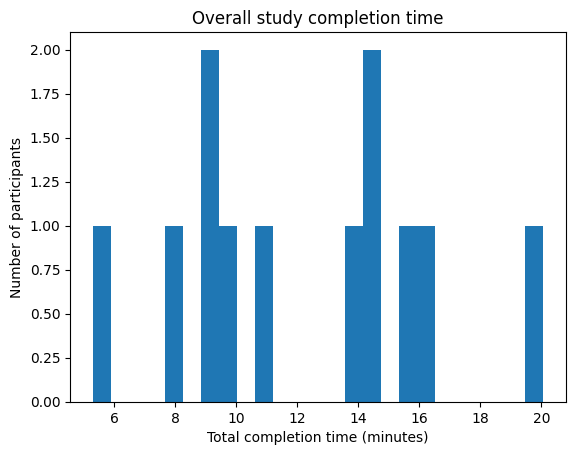

In [20]:
# Participant-level completion time (minutes)

df_raw['experiment_start_time'] = pd.to_datetime(
    df_raw['experiment_start_time'], unit='ms'
)
df_raw['exit_time'] = pd.to_datetime(
    df_raw['exit_time'], unit='ms'
)

df_raw['total_time_min'] = (
    df_raw['exit_time'] - df_raw['experiment_start_time']
).dt.total_seconds() / 60

# Plot
plt.figure()
plt.hist(df_raw['total_time_min'], bins=25)
plt.xlabel('Total completion time (minutes)')
plt.ylabel('Number of participants')
plt.title('Overall study completion time')
plt.show()

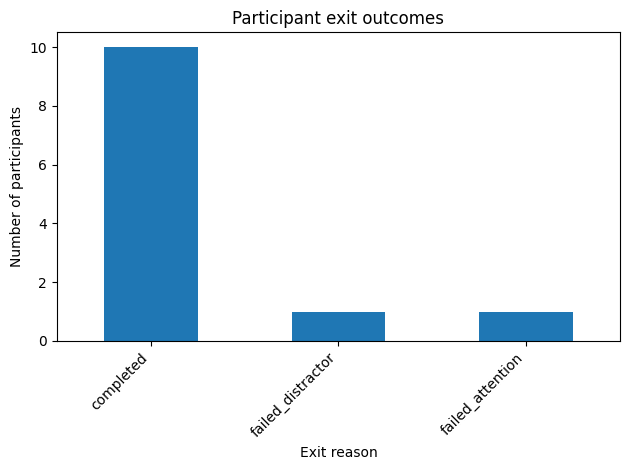

In [17]:
# Dropouts vs completions
exit_counts = df_raw['exit_reason'].value_counts()

plt.figure()
exit_counts.plot(kind='bar')
plt.xlabel('Exit reason')
plt.ylabel('Number of participants')
plt.title('Participant exit outcomes')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


ValueError: not enough values to unpack (expected 2, got 0)

<Figure size 800x500 with 0 Axes>

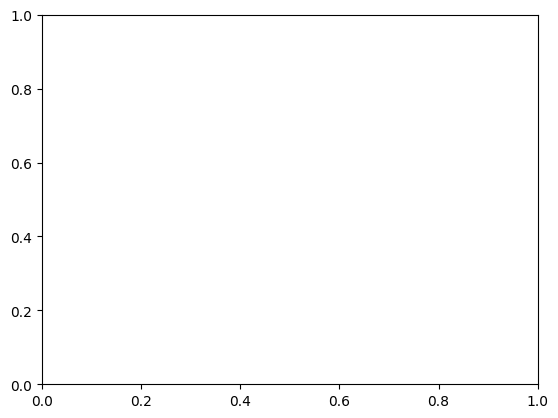

In [19]:
# Trial-level reaction times (seconds)
# Filter valid RTs
df_rt = df[(~df['timed_out']) & (df['rt'].notna())].copy()

# Convert ms → seconds
df_rt['rt_sec'] = df_rt['rt'] / 1000

plt.figure(figsize=(8, 5))
df_rt.boxplot(column='rt_sec', by='trial_type')

plt.ylabel('Reaction time (seconds)')
plt.xlabel('Trial type')
plt.title('Reaction times by trial type')
plt.suptitle('')

plt.xticks(rotation=30, ha='right')
plt.tight_layout()
plt.show()


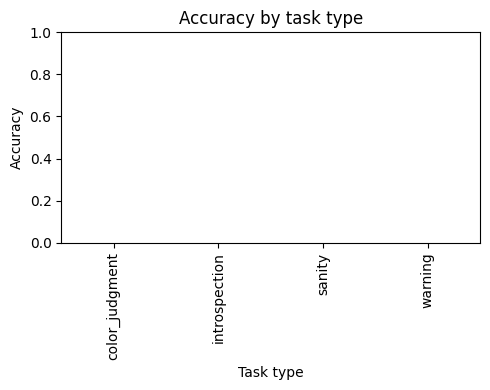

In [ ]:
# Cell 4: Accuracy by task type

df_scored = df[df['is_correct'].notna()].copy()

# Convert True/False -> 1/0
df_scored['is_correct_num'] = df_scored['is_correct'].astype(int)

accuracy_by_task = (
    df_scored
    .groupby('task_type')['is_correct_num']
    .mean()
    .sort_values()
)

plt.figure(figsize=(5, 4))
accuracy_by_task.plot(kind='bar')
plt.ylim(0, 1)
plt.ylabel('Accuracy')
plt.xlabel('Task type')
plt.title('Accuracy by task type')
plt.tight_layout()
plt.show()


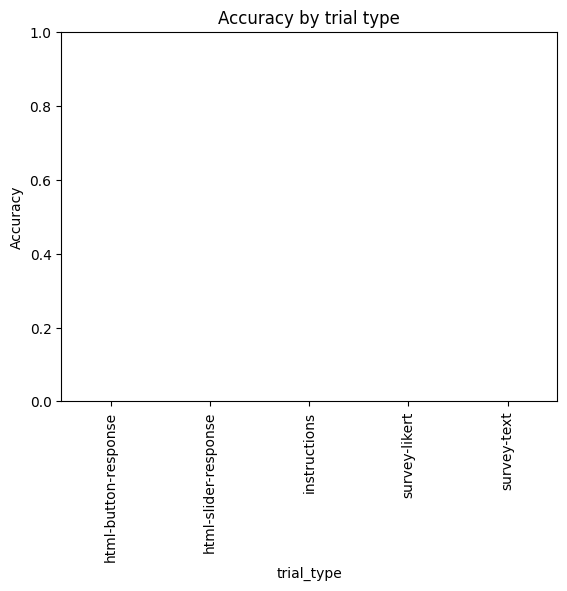

In [ ]:
#Color–concept entanglement proxy
# Interesting angle: does accuracy drop when distractor errors increase?

plt.figure()
plt.scatter(df['distractor_errors'], df['is_correct'].astype(int), alpha=0.2)
plt.xlabel('Number of distractor errors')
plt.ylabel('Correct (1=yes, 0=no)')
plt.title('Accuracy vs distractor interference')
plt.show()

#Certainty vs correctness

certainty_stats = (
    df.groupby('is_correct')['certainty']
      .mean()
)

plt.figure()
certainty_stats.plot(kind='bar')
plt.xticks([0, 1], ['Incorrect', 'Correct'], rotation=0)
plt.ylabel('Mean certainty')
plt.title('Metacognition: certainty tracks correctness')
plt.show()

# Learning or fatigue over time

# Order trials within participant

df_sorted = df.sort_values(['PROLIFIC_PID', 'trial_index'])
df_sorted['rolling_accuracy'] = (
    df_sorted.groupby('PROLIFIC_PID')['is_correct']
             .rolling(window=10, min_periods=5)
             .mean()
             .reset_index(level=0, drop=True)
)

plt.figure()
plt.plot(df_sorted['rolling_accuracy'], alpha=0.5)
plt.ylim(0, 1)
plt.ylabel('Rolling accuracy')
plt.xlabel('Trial (within participant)')
plt.title('Learning / fatigue effects over trials')
plt.show()

# Speed–accuracy tradeoff 

plt.figure()
plt.scatter(df_rt['rt'], df_rt['is_correct'].astype(int), alpha=0.2)
plt.xlabel('Reaction time (ms)')
plt.ylabel('Correct (1=yes, 0=no)')
plt.title('Speed–accuracy tradeoff')
plt.show()

#  Flag suspicious participants

participant_stats = (
    df.groupby('PROLIFIC_PID')
      .agg(
          mean_rt=('rt', 'mean'),
          accuracy=('is_correct', 'mean'),
          n_trials=('trial_index', 'count')
      )
)

fast_rt_threshold = participant_stats['mean_rt'].quantile(0.05)
low_acc_threshold = 0.55

suspicious = participant_stats[
    (participant_stats['mean_rt'] < fast_rt_threshold) |
    (participant_stats['accuracy'] < low_acc_threshold)
]

print(f"Flagged participants: {len(suspicious)}")
suspicious.head()
